In [ ]:
!pip install scikit-learn
import json
import string
import pprint
import glob
import itertools
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
maps = glob.glob("drive/MyDrive/IAC/*.json")

In [ ]:
with open(maps[0]) as f:
  data = json.loads(f.read())

In [3]:
'''
    conclusionPremiseDict Create dictionary of pairs with an identifier with the following form: 
    {id: {"conclusion": <SINGLE_CONCLUSION>, "premises":[<LIST_OF_PREMISES>]}}
'''
def conclusionPremiseDict(premises, conclusions):
    pairs = {}
    for i, x in enumerate(conclusions):
        pairs[i] = {'conclusion':x, 'premises':[]}
        id_to = x['fromID']
        for p in premises:
            if p['toID'] == id_to:
                pairs[i]['premises'].append(p)
                
    return pairs


'''
    aduPairs create list of ADU pairs containing connected conclusion and premise [[conclusion, premise]] 
'''
def aduPairs(edgePairs, nodesById):
    aduPair = []
    for pair in edgePairs.values():
        for p in pair['premises']:
          aduPair.append([nodesById[pair['conclusion']['toID']]['text'], nodesById[p['fromID']]['text']])
    return(aduPair)


'''
    pairs creates conclusion - premise pairs for one map
'''
def pairs(map):
    with open(map) as f:
        data = json.loads(f.read())
    #Creating nodesById dictionary which has nodeID as key and whole node as value for more efficient data extraction.
    nodesById = {}
    for _, node in enumerate(data['nodes']):
        nodesById[node['nodeID']] = node
    #Premises are nodes that have ingoing edges that are type 'RA' and outgoing edges that are type 'I'.
    premises = [x for x in data['edges'] if nodesById[x['fromID']]['type'] == 'I' and nodesById[x['toID']]['type'] == 'RA' ]

    #Conclusions are nodes that have ingoing edges that are type 'I' and outgoing edges that are type 'RA'.
    conclusions = [x for x in data['edges'] if nodesById[x['toID']]['type'] == 'I' and nodesById[x['fromID']]['type'] == 'RA' ]
    edgePairs = conclusionPremiseDict(premises, conclusions)
    adus = aduPairs(edgePairs, nodesById)
    return adus, conclusions, premises, nodesById


'''
    comb makes combination of conclusions and premises lists and returns list of pairs that are not conclusion-premise pairs 
'''
def comb(conclusions, premises, l, nodesById):
    combList = [(x,y) for x in conclusions for y in premises] 
    smallCombList = []
    for _ in range(l):
        p = random.choice(combList)
        smallCombList.append([nodesById[p[0]['toID']]['text'], nodesById[p[1]['fromID']]['text']])
    return smallCombList

In [ ]:
'''
    truePairs is list of all conclusion-premise pairs; falsePairs is list od conclusion-premise non pairs
'''
truePairs = []
conclusions = []
premises = []
nodesById = {}

for m in maps:
    adus, c, p, n = pairs(m)
    truePairs.extend(adus)
    conclusions.extend(c)
    premises.extend(p)
    nodesById = {**nodesById, **n}

falsePairs = comb(conclusions, premises, len(truePairs), nodesById)

In [ ]:
!pip install tensorflow_text
!pip install simpleneighbors

In [ ]:
import json
import os
import bokeh
import bokeh.models
import bokeh.plotting
import numpy as np
import os
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer
import sklearn.metrics.pairwise

from simpleneighbors import SimpleNeighbors
from tqdm import tqdm
from tqdm import trange

In [ ]:
def get_similarity(embeddings_1, embeddings_2):
  """Calculate cosine simiarity between two vectors.
     *[check similarity measure based on arccos]
     
     Args:
         - embeddings1, embeddings2 - vectors with sentence|word embeddings
         
     Returns:
         - sim, cosine - similarity measures
  """
  cosine = sklearn.metrics.pairwise.cosine_similarity(embeddings_1, embeddings_2)
  sim = 1 - np.arccos(cosine)/np.pi
  return sim, cosine

In [ ]:
def embed_text(text, model):
  """Embed text as an embedding via universal sentence encoder model.
     Args:
         - text - text to encode
         - model - universal sentence encoder model 

    Returns:
         - vector embedding of text
  """
  return model(text)

In [ ]:
# The 16-language multilingual module
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3' #@param ['https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3']
model = hub.load(module_url)

In [ ]:
def embed_pair(pair, model):
  """Embed conclusion and premises from one pair.
  
  Args:
    - pair - dictionary of conclusion and premises
    
  Returns:
    - embed_conclusion - embedding of conclusion
    - embed_premises - embedding of premises
  """
  embed_conclusion = embed_text(pair[0], model)
  embed_premise = embed_text(pair[1],model)
  return embed_conclusion, embed_premise

In [ ]:
embed_conclusion, embed_premises = embed_pair(truePairs[0], model)

In [ ]:
def getsimforpair(prem,conc):
  """Given premise and conclusion returns similarity measure

  Args:
      - prem - embeded representation of the premise
      - conc - embeded representation of the conclusion
  Returns: 
      - sim_pair - similarity measure
  """
  sim_pair = get_similarity(prem,conc)
  return sim_pair

In [ ]:
getsimforpair(embed_conclusion, embed_premises)

(array([[0.5797051]], dtype=float32), array([[0.24779238]], dtype=float32))

In [ ]:
def loopallpairs(pairlist):
  """Given list of pairs of premises and conclusions returns list of similarity measures for each pair in the corpus

  Args:
      - pairlist - list of pairs of premises and conclusions (raw text)
  Returns: 
      - simlist - list of similarity measure for each pair (raw text)
  """
  for pair in pairlist:
    conc = embed_text(pair[0], model)
    prem = embed_text(pair[1], model)
    simforpair = getsimforpair(prem,conc)
    simlist.append(simforpair)
  pairssimlist = zip(pairlist,simlist)
  return pairssimlist

In [ ]:
def makesimlist(simlist,label,measure):
  """
    Given list of list of similarity measure for each pairs makes list of similarity measurements plus labels
  
  Args:
    - simlist - list of similarity measure for each pair
    - label (0 false or 1 for true)
    - measure: 0 or 1
  """
  simtable = pd.DataFrame(simlist)
  simlistsim = simtable[measure] 
  simlistsim_flattened = [val for sublist in simlistsim for val in sublist]
  simtable = pd.DataFrame(simlistsim_flattened)
  simtable["label"] = label
  return simtable

In [ ]:
def loopallpairs(pairlist):
  """Given list of pairs of premises and conclusions returns list of similarity measures for each pair in the corpus

  Args:
      - pairlist - list of pairs of premises and conclusions (raw text)
  Returns: 
      - simlist - list of similarity measure for each pair (raw text)
  """
  simlist = []
  for pair in pairlist:
    conc = embed_text(pair[0], model)
    prem = embed_text(pair[1], model)
    simforpair = getsimforpair(prem,conc)
    simlist.append(simforpair)
  return simlist

In [ ]:
all_true_pairssimlist = loopallpairs(truePairs)

In [ ]:
all_false_pairssimlist = loopallpairs(falsePairs)

In [ ]:
all_false_pairssimlist[0]

(array([[0.52479076]], dtype=float32), array([[0.07780383]], dtype=float32))

In [1]:
all_true_pairssimlistSIMtable = makesimlist(all_true_pairssimlist,"1", 0)
all_true_pairssimlistCOStable = makesimlist(all_true_pairssimlist,"1", 1)
all_false_pairssimlistSIMtable = makesimlist(all_false_pairssimlist,"0", 0)
all_false_pairssimlistCOStable = makesimlist(all_false_pairssimlist,"0", 1)

database = []
database = pd.concat([all_false_pairssimlistSIMtable, all_true_pairssimlistSIMtable], axis=0)
from sklearn.utils import shuffle
database = shuffle(database)


'''
    write data to .csv file
'''
myFile = open('BK PROJEKT 2 SWĘDROWSKI.csv', 'w')
with myFile:    
    myFields = ['similarity', 'feature']
    writer = csv.DictWriter(myFile, fieldnames=myFields)    
    writer.writeheader()
    for i,j in zip(database[0], database['label']):
        writer.writerow({'similarity' : i, 'feature': j})

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(database, test_size=0.2)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import csv
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl

trainSamples = np.asarray(list(train[0]))
trainLabels = list(train['label'])
for i in range(len(trainLabels)):
    trainLabels[i] = float(trainLabels[i])

trainLabels = np.asarray(trainLabels)

testSamples = np.asarray(list(test[0]))
testLabels = list(test['label'])
for i in range(len(testLabels)):
    testLabels[i] = float(testLabels[i])
testLabels = np.asarray(testLabels)

bb = []
for i in testLabels:
    bb.append(type(i))
dd = set(bb)
print(dd)

{<class 'numpy.float64'>}


"\nfor i in range(len(trainLabels)):\n  #trainLabels[i] = np.array(float(trainLabels[i]))\n  trainLabels[i] = np.asarray(trainLabels[i]).astype('float32')\n  "

In [2]:
'''
  make model
'''
model = tf.keras.Sequential([
    Dense(units=64, input_shape=(1,), activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='sigmoid')
])
model.summary()


'''
  train model
'''
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x=trainSamples, y=trainLabels, validation_split = 0.03, batch_size=24, epochs=75, shuffle=True, verbose=1)


'''
  predictions
'''
predictions = model.predict(x=testSamples, batch_size=1, verbose=0)
roundedPredictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true = testLabels, y_pred = roundedPredictions)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix,', cmap=mpl.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:np.newaxis]
        print('Normalized confusiom matrix')
    else:
        print('Confusion matrix without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Prawdziwe')
    plt.xlabel('Przewidywane')
    plt.show()

cm_plot_labels = ['nie para', 'para']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Macierz pomyłek")

print(len(trainSamples), len(trainLabels))
model.evaluate(testSamples, testLabels, batch_size=2)

NameError: ignored

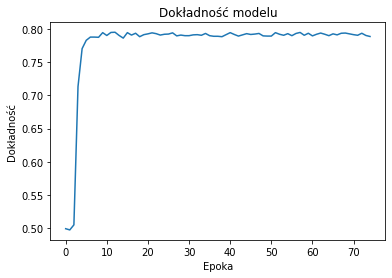

In [ ]:
plt.plot(hist.history['accuracy'])
plt.title('Dokładność modelu')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.show()

In [ ]:
#all_true_pairssimlistSIMtable.plot.hist(by=all_true_pairssimlistSIMtable[0], bins=10)

In [ ]:
#all_false_pairssimlistSIMtable.plot.hist(by=all_false_pairssimlistSIMtable[0], bins=10)

In [ ]:
#all_true_pairssimlistCOStable.plot.hist(by=all_true_pairssimlistCOStable[0], bins=10)

In [ ]:
#all_false_pairssimlistCOStable.plot.hist(by=all_false_pairssimlistCOStable[0], bins=10)

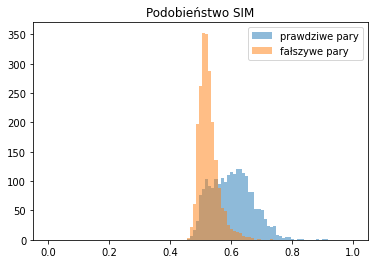

In [ ]:
bins = np.linspace(0, 1, 100)
plt.hist(all_true_pairssimlistSIMtable[0], bins, alpha=0.5, label='prawdziwe pary')
plt.hist(all_false_pairssimlistSIMtable[0], bins, alpha=0.5, label='fałszywe pary')
plt.legend(loc='upper right')
plt.title("Podobieństwo SIM") 
plt.show()

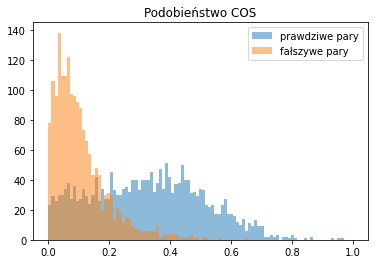

In [ ]:
bins = np.linspace(0, 1, 100)
plt.hist(all_true_pairssimlistCOStable[0], bins, alpha=0.5, label='prawdziwe pary')
plt.hist(all_false_pairssimlistCOStable[0], bins, alpha=0.5, label='fałszywe pary')
plt.legend(loc='upper right')
plt.title("Podobieństwo COS") 
plt.show()

In [ ]:
from sklearn import metrics

trainSamples_np = trainSamples.reshape(-1, 1)
testSamples_np = testSamples.reshape(-1, 1)

              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80       429
         1.0       0.85      0.70      0.77       438

    accuracy                           0.79       867
   macro avg       0.79      0.79      0.78       867
weighted avg       0.79      0.79      0.78       867

0.7854671280276817
Confusion matrix without normalization
[[374  55]
 [131 307]]


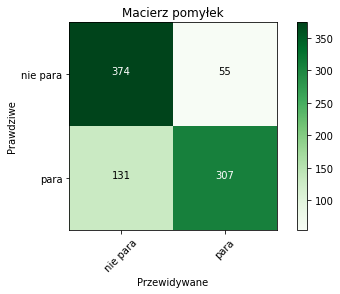

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(trainSamples_np, trainLabels)

predictions = lr_model.predict(testSamples_np)
metrics.confusion_matrix(testLabels, predictions)
print(metrics.classification_report(testLabels,predictions))
print(metrics.accuracy_score(testLabels,predictions))

cm = confusion_matrix(y_true = testLabels, y_pred = predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Macierz pomyłek")

              precision    recall  f1-score   support

         0.0       0.74      0.88      0.80       429
         1.0       0.86      0.69      0.77       438

    accuracy                           0.79       867
   macro avg       0.80      0.79      0.78       867
weighted avg       0.80      0.79      0.78       867

0.7854671280276817
Confusion matrix without normalization
[[378  51]
 [135 303]]


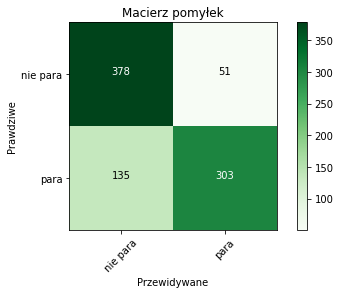

In [ ]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(trainSamples_np, trainLabels)

predictions = svc_model.predict(testSamples_np)
metrics.confusion_matrix(testLabels, predictions)
print(metrics.classification_report(testLabels,predictions))
print(metrics.accuracy_score(testLabels,predictions))

cm = confusion_matrix(y_true = testLabels, y_pred = predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Macierz pomyłek")